In [9]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

EfficientNetB0

In [19]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

input_dir = 'data/images'
output_dir = 'data/processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [12]:
train_dir = 'processed_images'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [13]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='max',
    verbose=1
    )

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='max',
    verbose=1,
    restore_best_weights=True
    )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 1127s 6s/step - accuracy: 0.3919 - loss: 2.1520 - val_accuracy: 0.0476 - val_loss: 3.1121
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1016s 6s/step - accuracy: 0.7593 - loss: 0.7531 - val_accuracy: 0.0490 - val_loss: 4.0502
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 992s 6s/step - accuracy: 0.8383 - loss: 0.5069 - val_accuracy: 0.0876 - val_loss: 4.1369
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 992s 6s/step - accuracy: 0.8701 - loss: 0.3950 - val_accuracy: 0.2257 - val_loss: 3.2273
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1072s 6s/step - accuracy: 0.8817 - loss: 0.3572 - val_accuracy: 0.4881 - val_loss: 1.8752
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1034s 6s/step - accuracy: 0.9029 - loss: 0.3021 - val_accuracy: 0.5652 - val_loss: 1.4941
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 994s 6s/step - accuracy: 0.9114 - loss: 0.2684 - val_accuracy: 0.5457 - val_loss: 1.6589
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1003s 6s/step - accuracy: 0.9136 - loss: 0.2510 - val_accuracy: 

In [18]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

165/165 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9591 - loss: 0.1113
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6470 - loss: 1.4725
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6427 - loss: 1.4606
Train accuracy: 0.9604, Validation accuracy: 0.6500, Test accuracy: 0.6533


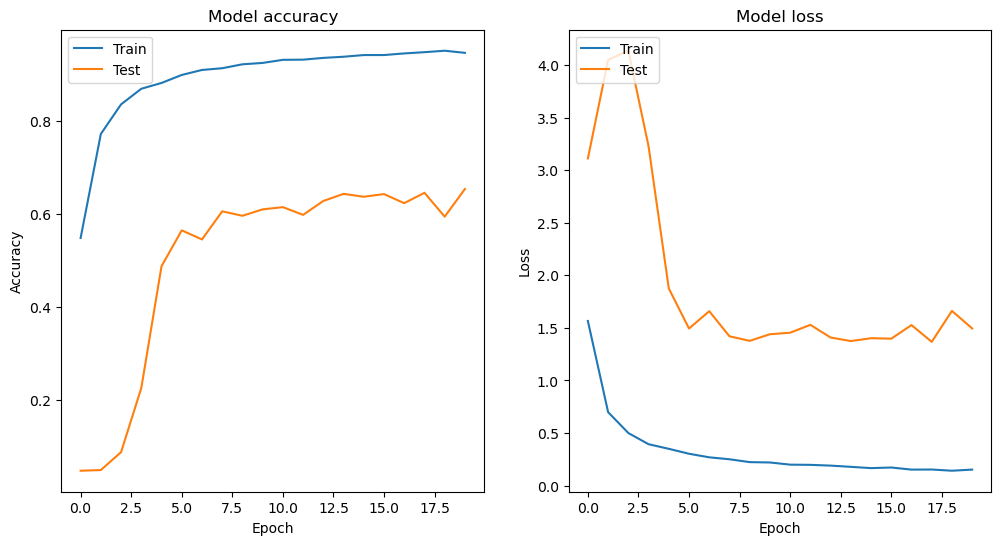

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

test_generator.reset()
Y_pred = model.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
                   precision    recall  f1-score   support

     agricultural       0.03      0.08      0.04        50
         airplane       0.00      0.00      0.00        50
  baseballdiamond       0.04      0.04      0.04        50
            beach       0.00      0.00      0.00        50
        buildings       0.04      0.02      0.03        50
        chaparral       0.03      0.06      0.04        50
 denseresidential       0.02      0.02      0.02        50
           forest       0.00      0.00      0.00        50
          freeway       0.07      0.04      0.05        50
       golfcourse       0.12      0.22      0.15        50
           harbor       0.09      0.08      0.09        50
     intersection       0.02      0.02      0.02        50
mediumresidential       0.00      0.00      0.00        50
   mobilehomepark       0.00      0.00      0.00        50
         overpass       0.04      0.10      0.06        50
       parkinglo

In [17]:
# Save model for hosting in Streamlit
model.save('models/efficientnet_model.h5')